In [7]:
"""MiniRocket transformer."""

__maintainer__ = []
__all__ = ["MiniRocket"]

import multiprocessing
from itertools import combinations

import numpy as np
from numba import get_num_threads, njit, prange, set_num_threads, vectorize

from aeon.transformations.collection import BaseCollectionTransformer


class MiniRocket(BaseCollectionTransformer):
    """MINImally RandOm Convolutional KErnel Transform (MiniRocket).

     MiniRocket [1]_ is an almost deterministic version of Rocket. It creates
     convolutions of length 9 with weights restricted to two values, and uses 84 fixed
     convolutions with six of one weight, three of the second weight to seed dilations.


    Parameters
    ----------
     n_kernels : int, default=10,000
        Number of random convolutional kernels. The number of kernels used is rounded
        down to the nearest multiple of 84, unless a value of less than 84 is passec,
        in which case it is set to 84.
     max_dilations_per_kernel : int, default=32
         Maximum number of dilations per kernel.
     n_jobs : int, default=1
         The number of jobs to run in parallel for `transform`. ``-1`` means using all
         processors.
     random_state : None or int, default = None
         Seed for random number generation.

    Attributes
    ----------
     self.parameters : Tuple (int32[:], int32[:], int32[:], int32[:], float32[:])
         n_channels_per_comb, channel_indices, dilations, n_features_per_dilation,
         biases

    See Also
    --------
     Rocket, MultiRocket, Hydra

    References
    ----------
     .. [1] Dempster, Angus and Schmidt, Daniel F and Webb, Geoffrey I,
         "MINIROCKET: A Very Fast (Almost) Deterministic Transform for Time Series
         Classification",2020,
         https://dl.acm.org/doi/abs/10.1145/3447548.3467231,
         https://arxiv.org/abs/2012.08791

    Notes
    -----
     Directly adapted from the original implementation
     https://github.com/angus924/minirocket.

    Examples
    --------
     >>> from aeon.transformations.collection.convolution_based import MiniRocket
     >>> from aeon.datasets import load_unit_test
     >>> X_train, y_train = load_unit_test(split="train")
     >>> X_test, y_test = load_unit_test(split="test")
     >>> trf = MiniRocket(n_kernels=512)
     >>> trf.fit(X_train)
     MiniRocket(n_kernels=512)
     >>> X_train = trf.transform(X_train)
     >>> X_test = trf.transform(X_test)
    """

    _tags = {
        "output_data_type": "Tabular",
        "algorithm_type": "convolution",
        "capability:multivariate": True,
        "capability:multithreading": True,
    }
    # indices for the 84 kernels used by MiniRocket
    _indices = np.array([_ for _ in combinations(np.arange(9), 3)], dtype=np.int32)

    def __init__(
        self,
        n_kernels=20_000,
        max_dilations_per_kernel=32,
        n_jobs=1,
        random_state=None,
    ):
        self.n_kernels = n_kernels
        self.max_dilations_per_kernel = max_dilations_per_kernel
        self.n_jobs = n_jobs
        self.random_state = random_state
        super().__init__()

    def _fit(self, X, y=None):
        """Fits dilations and biases to input time series.

        Parameters
        ----------
        X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
            Collection of time series to transform
        y : ignored argument for interface compatibility

        Returns
        -------
        self
        """
        random_state = (
            np.int32(self.random_state) if isinstance(self.random_state, int) else None
        )
        _, n_channels, n_timepoints = X.shape
        if n_timepoints < 9:
            raise ValueError(
                f"n_timepoints must be >= 9, but found {n_timepoints};"
                " zero pad shorter series so that n_timepoints == 9"
            )
        X = X.astype(np.float32)
        if self.n_kernels < 84:
            self.n_kernels_ = 84
        else:
            self.n_kernels_ = self.n_kernels
        self.parameters = _static_fit(
            X, self.n_kernels_, self.max_dilations_per_kernel, random_state
        )
        return self

    def _transform(self, X, y=None):
        """Transform input time series.

        Parameters
        ----------
        X : 3D np.ndarray of shape (n_cases, n_channels, n_timepoints)
            Collection of time series to transform
        y : ignored argument for interface compatibility

        Returns
        -------
        pandas DataFrame, transformed features
        """
        X = X.astype(np.float32)
        _, n_channels, n_timepoints = X.shape
        # change n_jobs dependend on value and existing cores
        prev_threads = get_num_threads()
        if self.n_jobs < 1 or self.n_jobs > multiprocessing.cpu_count():
            n_jobs = multiprocessing.cpu_count()
        else:
            n_jobs = self.n_jobs
        set_num_threads(n_jobs)
        if n_channels == 1:
            X = X.squeeze(1)
            X_ = _static_transform_uni(X, self.parameters, MiniRocket._indices)
        else:
            X_ = _static_transform_multi(X, self.parameters, MiniRocket._indices)
        set_num_threads(prev_threads)
        return X_


def _fit_dilations(n_timepoints, n_features, max_dilations_per_kernel):
    n_kernels = 84
    n_features_per_kernel = n_features // n_kernels
    true_max_dilations_per_kernel = min(n_features_per_kernel, max_dilations_per_kernel)
    multiplier = n_features_per_kernel / true_max_dilations_per_kernel
    max_exponent = np.log2((n_timepoints - 1) / (9 - 1))
    dilations, n_features_per_dilation = np.unique(
        np.logspace(0, max_exponent, true_max_dilations_per_kernel, base=2).astype(
            np.int32
        ),
        return_counts=True,
    )
    n_features_per_dilation = (n_features_per_dilation * multiplier).astype(
        np.int32
    )  # this is a vector
    remainder = n_features_per_kernel - np.sum(n_features_per_dilation)
    i = 0
    while remainder > 0:
        n_features_per_dilation[i] += 1
        remainder -= 1
        i = (i + 1) % len(n_features_per_dilation)
    return dilations, n_features_per_dilation


def _quantiles(n):
    return np.array(
        [(_ * ((np.sqrt(5) + 1) / 2)) % 1 for _ in range(1, n + 1)], dtype=np.float32
    )


def _static_fit(X, n_features=20_000, max_dilations_per_kernel=32, seed=None):
    if seed is not None:
        np.random.seed(seed)
    _, n_channels, n_timepoints = X.shape
    n_kernels = 84
    dilations, n_features_per_dilation = _fit_dilations(
        n_timepoints, n_features, max_dilations_per_kernel
    )
    n_features_per_kernel = np.sum(n_features_per_dilation)
    quantiles = _quantiles(n_kernels * n_features_per_kernel)
    n_dilations = len(dilations)
    n_combinations = n_kernels * n_dilations
    max_n_channels = min(n_channels, 9)
    max_exponent = np.log2(max_n_channels + 1)
    n_channels_per_combination = (
        2 ** np.random.uniform(0, max_exponent, n_combinations)
    ).astype(np.int32)
    channel_indices = np.zeros(n_channels_per_combination.sum(), dtype=np.int32)
    n_channels_start = 0
    for combination_index in range(n_combinations):
        n_channels_this_combination = n_channels_per_combination[combination_index]
        n_channels_end = n_channels_start + n_channels_this_combination
        channel_indices[n_channels_start:n_channels_end] = np.random.choice(
            n_channels, n_channels_this_combination, replace=False
        )
        n_channels_start = n_channels_end
    biases = _fit_biases(
        X,
        n_channels_per_combination,
        channel_indices,
        dilations,
        n_features_per_dilation,
        quantiles,
        MiniRocket._indices,
        seed,
    )
    return (
        n_channels_per_combination,
        channel_indices,
        dilations,
        n_features_per_dilation,
        biases,
    )


@vectorize("float32(float32,float32)", nopython=True, cache=True)
def _PPV(a, b):
    if a > b:
        return 1
    return 0


@njit(
    "float32[:,:](float32[:,:],Tuple((int32[:],int32[:],int32[:],int32[:],float32["
    ":])), int32[:,:])",
    fastmath=True,
    parallel=True,
    cache=True,
)
def _static_transform_uni(X, parameters, indices):
    """Transform a 2D collection of univariate time series.

    Implemented separately to the multivariate version for numba efficiency reasons.
    See issue #1778.
    """
    n_cases, n_timepoints = X.shape
    (
        _,
        _,
        dilations,
        n_features_per_dilation,
        biases,
    ) = parameters
    n_kernels = len(indices)
    n_dilations = len(dilations)
    f = n_kernels * np.sum(n_features_per_dilation)
    features = np.zeros((n_cases, f), dtype=np.float32)
    for i in prange(n_cases):
        _X = X[i]
        A = -_X
        G = 3 * _X
        f_start = 0
        for j in range(n_dilations):
            _padding0 = j % 2
            dilation = dilations[j]
            padding = (8 * dilation) // 2
            n_features = n_features_per_dilation[j]
            C_alpha = np.zeros(n_timepoints, dtype=np.float32)
            C_alpha[:] = A
            C_gamma = np.zeros((9, n_timepoints), dtype=np.float32)
            C_gamma[4] = G
            start = dilation
            end = n_timepoints - padding
            for gamma_index in range(4):
                C_alpha[-end:] = C_alpha[-end:] + A[:end]
                C_gamma[gamma_index, -end:] = G[:end]
                end += dilation
            for gamma_index in range(5, 9):
                C_alpha[:-start] = C_alpha[:-start] + A[start:]
                C_gamma[gamma_index, :-start] = G[start:]
                start += dilation
            for k in range(n_kernels):
                f_end = f_start + n_features
                _padding1 = (_padding0 + k) % 2
                a, b, c = indices[k]
                C = C_alpha + C_gamma[a] + C_gamma[b] + C_gamma[c]
                if _padding1 == 0:
                    for f in range(n_features):
                        features[i, f_start + f] = _PPV(C, biases[f_start + f]).mean()
                else:
                    for f in range(n_features):
                        features[i, f_start + f] = _PPV(
                            C[padding:-padding], biases[f_start + f]
                        ).mean()

                f_start = f_end
    return features


@njit(
    "float32[:,:](float32[:,:,:],Tuple((int32[:],int32[:],int32[:],int32[:],float32["
    ":])), int32[:,:])",
    fastmath=True,
    parallel=True,
    cache=True,
)
def _static_transform_multi(X, parameters, indices):
    n_cases, n_channels, n_timepoints = X.shape
    (
        n_channels_per_combination,
        channel_indices,
        dilations,
        n_features_per_dilation,
        biases,
    ) = parameters
    n_kernels = len(indices)
    n_dilations = len(dilations)
    n_features = n_kernels * np.sum(n_features_per_dilation)
    features = np.zeros((n_cases, n_features), dtype=np.float32)
    for i in prange(n_cases):
        _X = X[i]
        A = -_X
        G = 3 * _X
        f_start = 0
        comb = 0
        n_channels_start = 0
        for j in range(n_dilations):
            _padding0 = j % 2
            dilation = dilations[j]
            padding = (8 * dilation) // 2
            n_features_this_dilation = n_features_per_dilation[j]
            C_alpha = np.zeros((n_channels, n_timepoints), dtype=np.float32)
            C_alpha[:] = A
            C_gamma = np.zeros((9, n_channels, n_timepoints), dtype=np.float32)
            C_gamma[4] = G
            start = dilation
            end = n_timepoints - padding
            for gamma_index in range(4):
                C_alpha[:, -end:] = C_alpha[:, -end:] + A[:, :end]
                C_gamma[gamma_index, :, -end:] = G[:, :end]
                end += dilation

            for gamma_index in range(5, 9):
                C_alpha[:, :-start] = C_alpha[:, :-start] + A[:, start:]
                C_gamma[gamma_index, :, :-start] = G[:, start:]
                start += dilation

            for kernel_index in range(n_kernels):
                f_end = f_start + n_features_this_dilation
                n_channels_this_combo = n_channels_per_combination[comb]
                n_channels_end = n_channels_start + n_channels_this_combo
                channels_this_combo = channel_indices[n_channels_start:n_channels_end]
                _padding1 = (_padding0 + kernel_index) % 2
                index_0, index_1, index_2 = indices[kernel_index]
                C = (
                    C_alpha[channels_this_combo]
                    + C_gamma[index_0][channels_this_combo]
                    + C_gamma[index_1][channels_this_combo]
                    + C_gamma[index_2][channels_this_combo]
                )
                C = np.sum(C, axis=0)
                if _padding1 == 0:
                    for feature_count in range(n_features_this_dilation):
                        features[i, f_start + feature_count] = _PPV(
                            C, biases[f_start + feature_count]
                        ).mean()
                else:
                    for feature_count in range(n_features_this_dilation):
                        features[i, f_start + feature_count] = _PPV(
                            C[padding:-padding],
                            biases[f_start + feature_count],
                        ).mean()
                f_start = f_end
                comb += 1
                n_channels_start = n_channels_end
    return features


@njit(
    "float32[:](float32[:,:,:],int32[:],int32[:],int32[:],int32[:],float32[:],"
    "int32[:,:],optional(int32))",  # noqa
    fastmath=True,
    parallel=False,
    cache=True,
)
def _fit_biases(
    X,
    n_channels_per_combination,
    channel_indices,
    dilations,
    n_features_per_dilation,
    quantiles,
    indices,
    seed,
):
    if seed is not None:
        np.random.seed(seed)
    n_cases, n_columns, n_timepoints = X.shape
    n_kernels = len(indices)
    n_dilations = len(dilations)
    n_features = n_kernels * np.sum(n_features_per_dilation)
    biases = np.zeros(n_features, dtype=np.float32)
    feature_index_start = 0
    combination_index = 0
    n_channels_start = 0
    for dilation_index in range(n_dilations):
        dilation = dilations[dilation_index]
        padding = ((9 - 1) * dilation) // 2
        n_features_this_dilation = n_features_per_dilation[dilation_index]
        for kernel_index in range(n_kernels):
            feature_index_end = feature_index_start + n_features_this_dilation
            n_channels_this_combination = n_channels_per_combination[combination_index]
            n_channels_end = n_channels_start + n_channels_this_combination
            channels_this_combination = channel_indices[n_channels_start:n_channels_end]
            _X = X[np.random.randint(n_cases)][channels_this_combination]
            A = -_X  # A = alpha * X = -X
            G = _X + _X + _X  # G = gamma * X = 3X
            C_alpha = np.zeros(
                (n_channels_this_combination, n_timepoints), dtype=np.float32
            )
            C_alpha[:] = A
            C_gamma = np.zeros(
                (9, n_channels_this_combination, n_timepoints), dtype=np.float32
            )
            C_gamma[9 // 2] = G
            start = dilation
            end = n_timepoints - padding
            for gamma_index in range(9 // 2):
                C_alpha[:, -end:] = C_alpha[:, -end:] + A[:, :end]
                C_gamma[gamma_index, :, -end:] = G[:, :end]
                end += dilation
            for gamma_index in range(9 // 2 + 1, 9):
                C_alpha[:, :-start] = C_alpha[:, :-start] + A[:, start:]
                C_gamma[gamma_index, :, :-start] = G[:, start:]
                start += dilation
            index_0, index_1, index_2 = indices[kernel_index]
            C = C_alpha + C_gamma[index_0] + C_gamma[index_1] + C_gamma[index_2]
            C = np.sum(C, axis=0)
            biases[feature_index_start:feature_index_end] = np.quantile(
                C, quantiles[feature_index_start:feature_index_end]
            )
            feature_index_start = feature_index_end
            combination_index += 1
            n_channels_start = n_channels_end
    return biases

In [8]:
"""MiniRocket classifier.

Pipeline classifier using the MiniRocket transformer and RidgeClassifierCV classifier.
"""

__maintainer__ = ["MatthewMiddlehurst"]
__all__ = ["MiniRocketClassifier"]

import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from aeon.base._base import _clone_estimator
from aeon.classification import BaseClassifier
#from aeon.transformations.collection.convolution_based import MiniRocket


class MiniRocketClassifier(BaseClassifier):
    """
    MiniRocket transformer using RidgeClassifierCV.

    This classifier transforms the input data using the MiniRocket [1]_ transformer
    extracting features from randomly generated kernels, performs a Standard scaling
    and fits a sklearn classifier using the transformed data (default classifier is
    RidgeClassifierCV).

    Parameters
    ----------
    n_kernels : int, default=10,000
        The number of kernels for the Rocket transform.
    max_dilations_per_kernel : int, default=32
        The maximum number of dilations per kernel.
    estimator : sklearn compatible classifier or None, default=None
        The estimator used. If None, a RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        is used.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both `fit` and `predict`.
        ``-1`` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    n_classes_ : int
        The number of classes.
    classes_ : list
        The classes labels.

    References
    ----------
    .. [1] Dempster, A., Schmidt, D.F. and Webb, G.I., 2021, August. Minirocket: A very
        fast (almost) deterministic transform for time series classification. In
        Proceedings of the 27th ACM SIGKDD conference on knowledge discovery & data
        mining (pp. 248-257).

    Examples
    --------
    >>> from aeon.classification.convolution_based import MiniRocketClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = MiniRocketClassifier(n_kernels=500)
    >>> clf.fit(X_train, y_train)
    MiniRocketClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multithreading": True,
        "capability:multivariate": True,
        "algorithm_type": "convolution",
    }

    def __init__(
        self,
        n_kernels=20000,
        max_dilations_per_kernel=32,
        estimator=None,
        class_weight=None,
        n_jobs=1,
        random_state=None,
    ):
        self.n_kernels = n_kernels
        self.max_dilations_per_kernel = max_dilations_per_kernel
        self.estimator = estimator

        self.class_weight = class_weight
        self.n_jobs = n_jobs
        self.random_state = random_state

        super().__init__()

    def _fit(self, X, y):
        """Fit Rocket variant to training data.

        Parameters
        ----------
        X : 3D np.ndarray
            The training data of shape = (n_cases, n_channels, n_timepoints).
        y : 3D np.ndarray
            The class labels, shape = (n_cases,).

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_" and sets is_fitted flag to True.
        """
        self.n_cases_, self.n_channels_, self.n_timepoints_ = X.shape

        self._transformer = MiniRocket(
            n_kernels=self.n_kernels,
            max_dilations_per_kernel=self.max_dilations_per_kernel,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
        self._scaler = StandardScaler(with_mean=False)
        self._estimator = _clone_estimator(
            (
                RidgeClassifierCV(
                    alphas=np.logspace(-3, 3, 10), class_weight=self.class_weight
                )
                if self.estimator is None
                else self.estimator
            ),
            self.random_state,
        )

        self.pipeline_ = make_pipeline(
            self._transformer,
            self._scaler,
            self._estimator,
        )
        self.pipeline_.fit(X, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = (n_cases,)
            Predicted class labels.
        """
        return self.pipeline_.predict(X)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts labels probabilities for sequences in X.

        Parameters
        ----------
        X : 3D np.ndarray of shape = (n_cases, n_channels, n_timepoints)
            The data to make predict probabilities for.

        Returns
        -------
        y : array-like, shape = (n_cases, n_classes_)
            Predicted probabilities using the ordering in classes_.
        """
        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self.pipeline_.predict_proba(X)
        else:
            dists = np.zeros((X.shape[0], self.n_classes_))
            preds = self.pipeline_.predict(X)
            for i in range(0, X.shape[0]):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    @classmethod
    def _get_test_params(cls, parameter_set="default"):
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            RocketClassifier provides the following special sets:
                 "results_comparison" - used in some classifiers to compare against
                    previously generated results where the default set of parameters
                    cannot produce suitable probability estimates

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        if parameter_set == "results_comparison":
            return {"n_kernels": 100}
        else:
            return {"n_kernels": 20, "max_dilations_per_kernel": 6}

In [9]:
import random

import numpy as np
import torch
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.backends.cudnn.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [10]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.fftpack import dct  # Import DCT from scipy
import librosa  # Ensure librosa is imported for loading audio files

# Custom Dataset Class
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

def pre_emphasis(signal, alpha=0.97):
    """Apply pre-emphasis filter."""
    return np.append(signal[0], signal[1:] - alpha * signal[:-1])

def framing(signal, frame_size, hop_size):
    """Split signal into overlapping frames."""
    num_frames = int(np.ceil(float(np.abs(len(signal) - frame_size)) / hop_size)) + 1
    pad_signal_length = num_frames * hop_size + frame_size
    z = np.zeros(pad_signal_length)
    z[:len(signal)] = signal
    
    frames = np.lib.stride_tricks.as_strided(z,
        shape=(num_frames, frame_size),
        strides=(z.strides[0] * hop_size, z.strides[0])).copy()
    
    return frames

def hamming_window(frame):
    """Apply Hamming window to a frame."""
    return np.hamming(len(frame)) * frame

def mel_filter_bank(num_filters, fft_size, sample_rate, low_freq=0, high_freq=None):
    """Create a Mel filter bank."""
    if high_freq is None:
        high_freq = sample_rate / 2
    
    # Convert frequency to Mel scale
    low_mel = 2595 * np.log10(1 + low_freq / 700)
    high_mel = 2595 * np.log10(1 + high_freq / 700)
    
    mel_points = np.linspace(low_mel, high_mel, num_filters + 2)
    hz_points = 700 * (10**(mel_points / 2595) - 1)
    
    bin_points = np.floor((fft_size + 1) * hz_points / sample_rate).astype(int)
    
    filters = np.zeros((num_filters, int(np.floor(fft_size / 2 + 1))))
    
    for n in range(1, num_filters + 1):
        filters[n - 1, bin_points[n - 1]:bin_points[n]] = \
            (np.arange(bin_points[n - 1], bin_points[n]) - bin_points[n - 1]) / (bin_points[n] - bin_points[n - 1])
        filters[n - 1, bin_points[n]:bin_points[n + 1]] = \
            (bin_points[n + 1] - np.arange(bin_points[n], bin_points[n + 1])) / (bin_points[n + 1] - bin_points[n])
    
    return filters

def compute_mfcc(signal, sample_rate=16000, n_mfcc=13, n_fft=400, hop_length=160):
    """Compute MFCC from scratch."""
    # Step 1: Pre-emphasis
    emphasized_signal = pre_emphasis(signal)

    # Step 2: Framing
    frames = framing(emphasized_signal, n_fft, hop_length)

    # Step 3: Apply Hamming window
    windowed_frames = np.array([hamming_window(frame) for frame in frames])

    # Step 4: FFT and Power Spectrum
    mag_frames = np.abs(np.fft.rfft(windowed_frames, n=n_fft)) ** 2

    # Step 5: Mel Filter Bank
    mel_filters = mel_filter_bank(n_mfcc, n_fft, sample_rate)
    
    # Step 6: Apply Mel filter bank to power spectrum
    mel_energies = np.dot(mag_frames, mel_filters.T)

    # Step 7: Logarithm of Mel energies
    log_mel_energies = np.log(mel_energies + np.finfo(float).eps)

    # Step 8: Discrete Cosine Transform (DCT)
    mfccs = dct(log_mel_energies, type=2, axis=1, norm='ortho')[:, :n_mfcc]

    return mfccs

def load_data_with_mfcc(directory, n_mfcc=13, n_fft=400, hop_size=160, target_length=16000):
    """Load data from a directory and extract MFCC features."""
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_path = os.path.join(class_dir, file_name)
                    signal, rate = librosa.load(file_path, sr=None)  # Load audio to get its length
                    
                    # Check if the audio signal length is less than the target length (16000 samples)
                    if len(signal) < target_length:
                        # Pad the signal to 16000 samples if it's too short
                        padding = target_length - len(signal)
                        signal = np.pad(signal, (0, padding), 'constant')

                    # Check if the audio length is greater than the target length (16000 samples)
                    if len(signal) > target_length:
                        # Truncate the signal to 16000 samples if it's too long
                        signal = signal[:target_length]

                    audio_length = len(signal)  # Length in samples
                    mfcc = compute_mfcc(signal, sample_rate=rate, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_size)
                    num_frames = mfcc.shape[1]

                    # Check if the first window is less than 25 ms (400 samples)
                    if num_frames > 0 and (num_frames * hop_size < 400):  
                        print(f"Stopping processing for {file_name}: first window is less than 30 ms.")
                        break
                    
                    X.append(mfcc)
                    y.append(label_map[label])
                    
                    # Display number of frames and audio length for each sample
                    #print(f"File: {file_name}, Label: {label}, Audio Length: {audio_length} samples, Number of frames: {num_frames}")

                    # Print total number of windows for each file
                    #print(f"Total number of windows for {file_name}: {num_frames}")

                    # Print shape of the feature vector (MFCC matrix)
                    #print(f"MFCC feature vector shape for {file_name}: {mfcc.shape}")

            else:
                continue  
            break  

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Feature array shape:", X.shape)  
    print("Labels array shape:", y.shape)

    return X, y, labels


# Section 3: Data Loading and Preprocessing
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_with_mfcc(directory)

# Reshape X for CNN input (add channel dimension if needed)
if X.size > 0:
   X = X[:, :, :]  




Feature array shape: (27692, 99, 13)
Labels array shape: (27692,)


In [11]:
# Reshape X for CNN input (swap dimensions 1 and 2)
if X.size > 0:
   X = X.transpose(0, 2, 1)  # Change shape from (23682, 50, 13) to (23682, 13, 50)
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# You can add your model training and evaluation code here.

In [12]:
clf = MiniRocketClassifier(random_state=42,n_kernels=20000)

In [13]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

MiniRocketClassifier(random_state=42)

In [14]:
X_transformed = clf._transformer.transform(X_train)

# Now `X_transformed` is your RDST feature matrix.
# You can store it in a numpy matrix or save it to a file if needed.
print("MiniRocket Feature Matrix Shape:", X_transformed.shape)


MiniRocket Feature Matrix Shape: (22153, 19992)


In [15]:
import numpy as np

# Save the feature matrix to a .npy file
np.save('X_transformed.npy', X_transformed)

# Confirm the file is saved
print("MiniRocket feature matrix saved to 'X_transformed.npy'")


MiniRocket feature matrix saved to 'X_transformed.npy'


In [16]:
# Predict on the test set
from sklearn.metrics import accuracy_score
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.8956490341216826


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.89618421747191
Recall (macro): 0.896261541537593
F1 Score (macro): 0.8953850828646415


In [18]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = clf.predict(X_test)

# Print the classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       445
           1       0.84      0.87      0.86       486
           2       0.92      0.90      0.91       479
           3       0.87      0.86      0.86       510
           4       0.87      0.89      0.88       473
           5       0.91      0.91      0.91       491
           6       0.94      0.93      0.94       465
           7       0.95      1.00      0.97       383
           8       0.95      0.94      0.95       445
           9       0.83      0.68      0.74       427
          10       0.86      0.91      0.89       480
          11       0.97      0.95      0.96       455

    accuracy                           0.90      5539
   macro avg       0.90      0.90      0.90      5539
weighted avg       0.90      0.90      0.89      5539



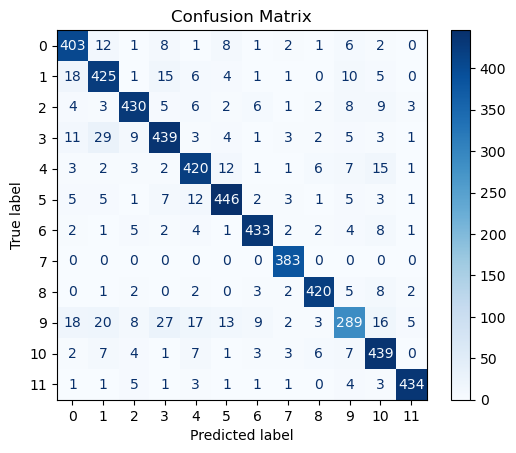

In [19]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


